# Building structured multi-plot grids
When exploring multi-dimensional data, a useful approach is to draw multiple instances of the same plot on different subsets of your dataset. This technique is sometimes called either “lattice” or “trellis” plotting, and it is related to the idea of “small multiples”. It allows a viewer to quickly extract a large amount of information about a complex dataset. Matplotlib offers good support for making figures with multiple axes; seaborn builds on top of this to directly link the structure of the plot to the structure of your dataset.

The figure-level functions are built on top of the objects discussed in this chapter of the tutorial. In most cases, you will want to work with those functions. They take care of some important bookkeeping that synchronizes the multiple plots in each grid. This chapter explains how the underlying objects work, which may be useful for advanced applications.

### Conditional small multiples
The FacetGrid class is useful when you want to visualize the distribution of a variable or the relationship between multiple variables separately within subsets of your dataset. A FacetGrid can be drawn with up to three dimensions: row, col, and hue. The first two have obvious correspondence with the resulting array of axes; think of the hue variable as a third dimension along a depth axis, where different levels are plotted with different colors.

Each of relplot(), displot(), catplot(), and lmplot() use this object internally, and they return the object when they are finished so that it can be used for further tweaking.

The class is used by initializing a FacetGrid object with a dataframe and the names of the variables that will form the row, column, or hue dimensions of the grid. These variables should be categorical or discrete, and then the data at each level of the variable will be used for a facet along that axis. For example, say we wanted to examine differences between lunch and dinner in the tips dataset:

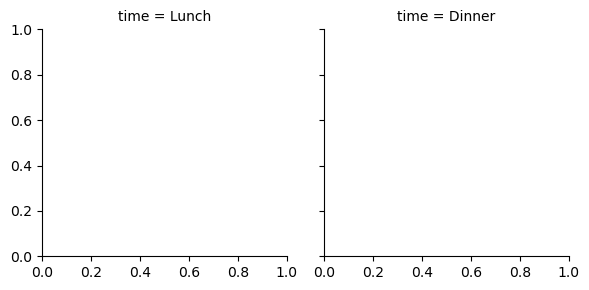

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="time")

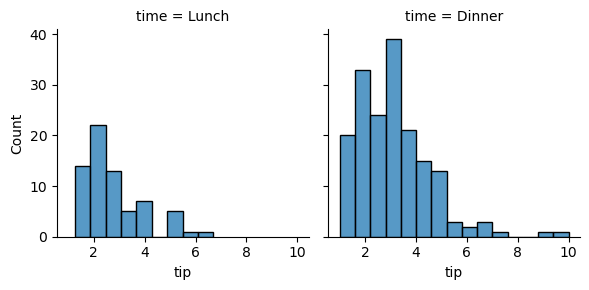

In [2]:
g = sns.FacetGrid(tips, col="time")
g.map(sns.histplot, "tip")

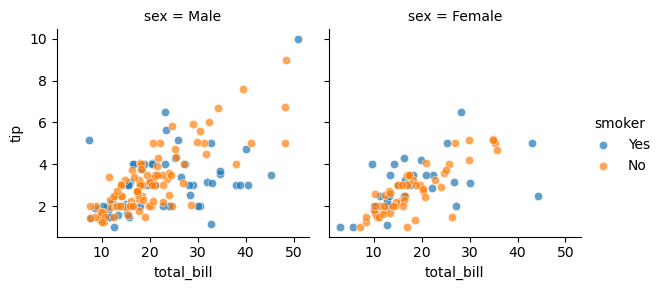

In [3]:
g = sns.FacetGrid(tips, col="sex", hue="smoker")
g.map(sns.scatterplot, "total_bill", "tip", alpha=.7)
g.add_legend()

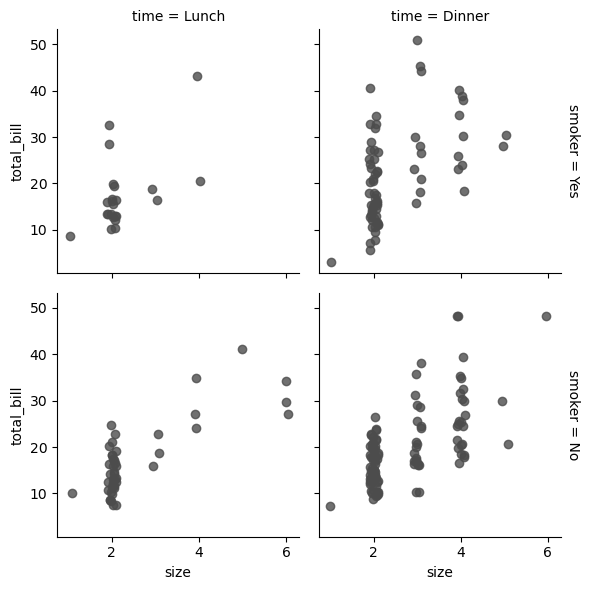

In [4]:
g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)
g.map(sns.regplot, "size", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

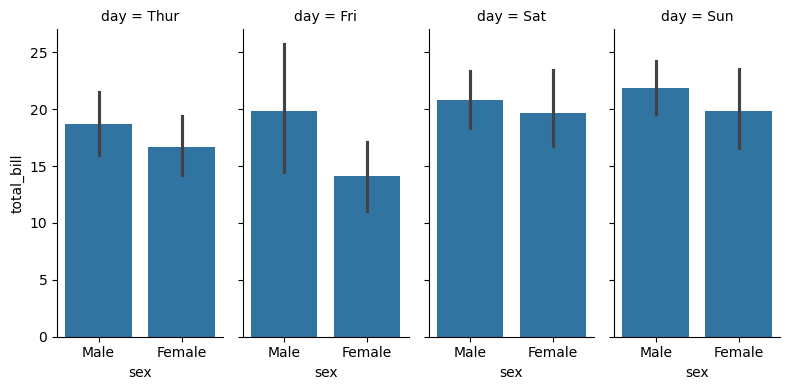

In [5]:
g = sns.FacetGrid(tips, col="day", height=4, aspect=.5)
g.map(sns.barplot, "sex", "total_bill", order=["Male", "Female"])

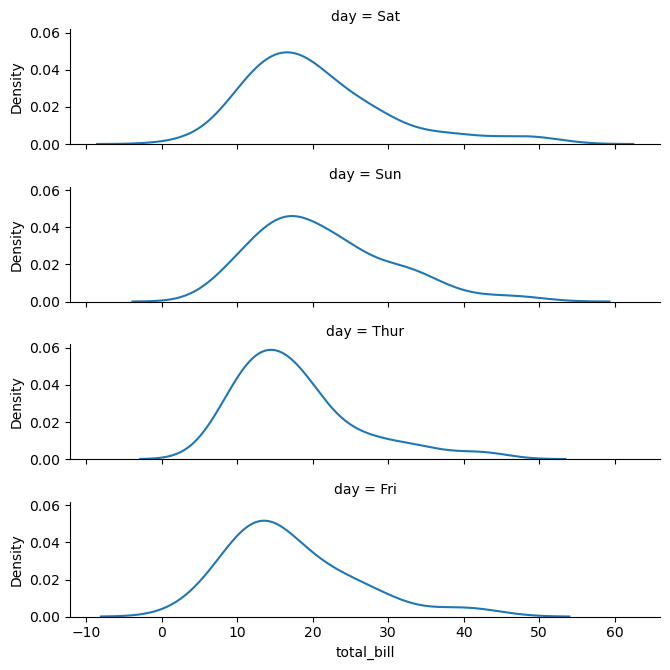

In [6]:
ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(tips, row="day", row_order=ordered_days,
                  height=1.7, aspect=4,)
g.map(sns.kdeplot, "total_bill")

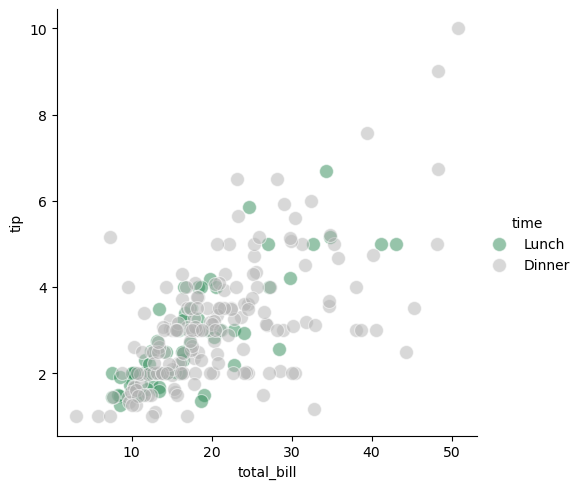

In [7]:
pal = dict(Lunch="seagreen", Dinner=".7")
g = sns.FacetGrid(tips, hue="time", palette=pal, height=5)
g.map(sns.scatterplot, "total_bill", "tip", s=100, alpha=.5)
g.add_legend()

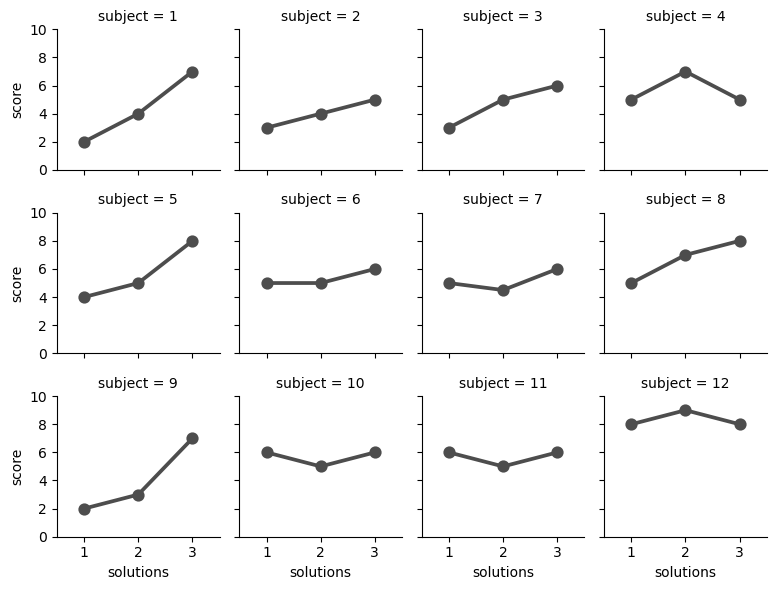

In [8]:
attend = sns.load_dataset("attention").query("subject <= 12")
g = sns.FacetGrid(attend, col="subject", col_wrap=4, height=2, ylim=(0, 10))
g.map(sns.pointplot, "solutions", "score", order=[1, 2, 3], color=".3", errorbar=None)

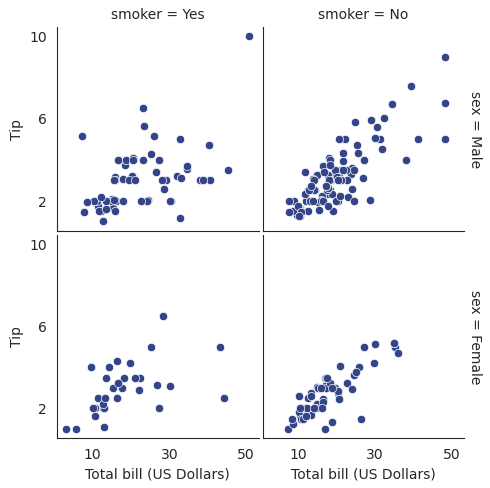

In [9]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tips, row="sex", col="smoker", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "total_bill", "tip", color="#334488")
g.set_axis_labels("Total bill (US Dollars)", "Tip")
g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
g.figure.subplots_adjust(wspace=.02, hspace=.02)

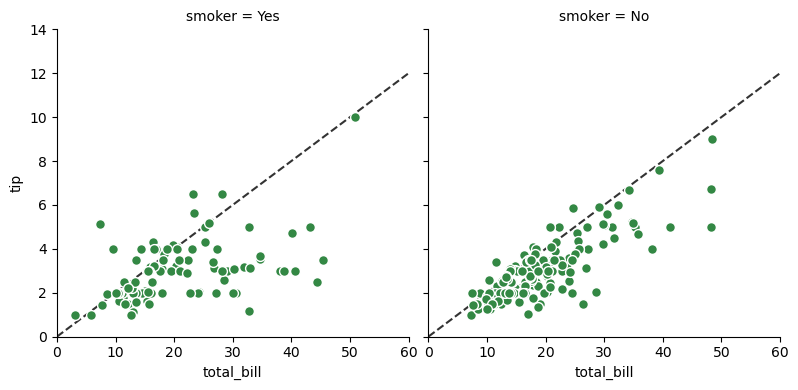

In [10]:
g = sns.FacetGrid(tips, col="smoker", margin_titles=True, height=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
g.set(xlim=(0, 60), ylim=(0, 14))

### Using custom functions
You’re not limited to existing matplotlib and seaborn functions when using FacetGrid. However, to work properly, any function you use must follow a few rules:

It must plot onto the “currently active” matplotlib Axes. This will be true of functions in the matplotlib.pyplot namespace, and you can call matplotlib.pyplot.gca() to get a reference to the current Axes if you want to work directly with its methods.

It must accept the data that it plots in positional arguments. Internally, FacetGrid will pass a Series of data for each of the named positional arguments passed to FacetGrid.map().

It must be able to accept color and label keyword arguments, and, ideally, it will do something useful with them. In most cases, it’s easiest to catch a generic dictionary of **kwargs and pass it along to the underlying plotting function.

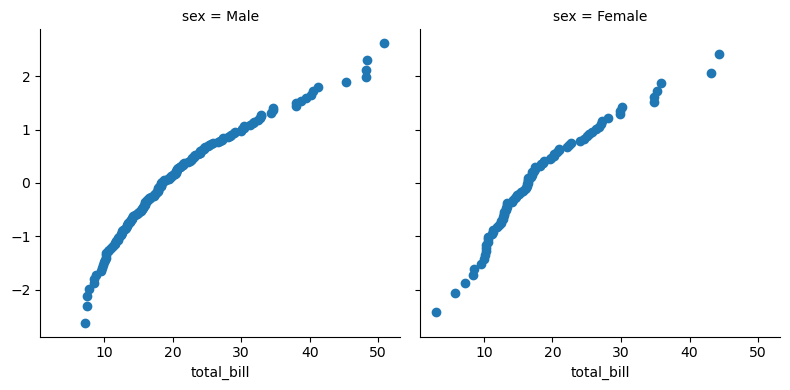

In [11]:
from scipy import stats
def quantile_plot(x, **kwargs):
    quantiles, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, quantiles, **kwargs)

g = sns.FacetGrid(tips, col="sex", height=4)
g.map(quantile_plot, "total_bill")

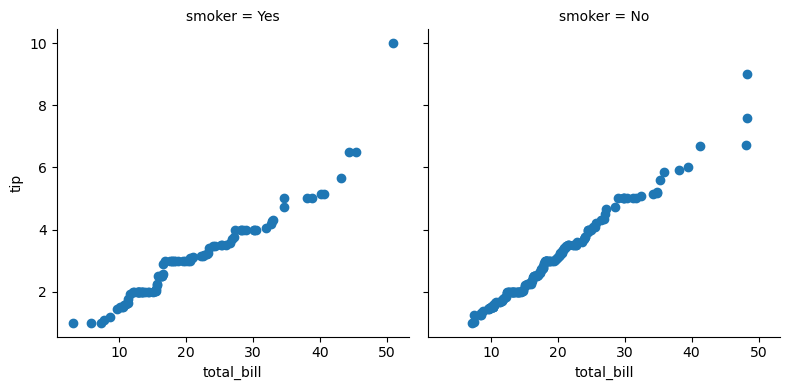

In [12]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = sns.FacetGrid(tips, col="smoker", height=4)
g.map(qqplot, "total_bill", "tip")

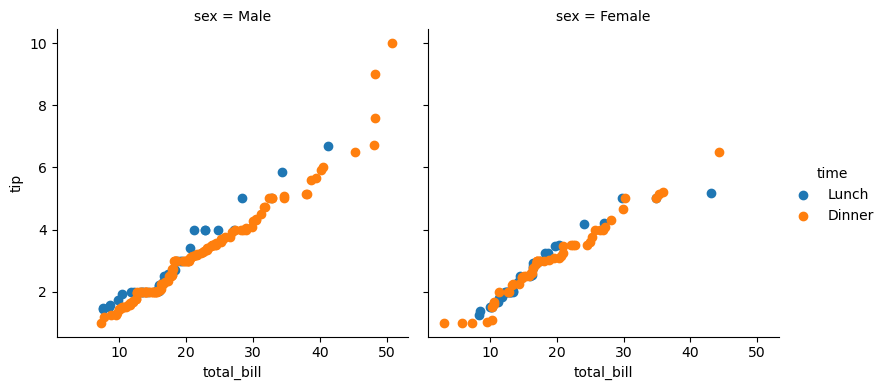

In [13]:
g = sns.FacetGrid(tips, hue="time", col="sex", height=4)
g.map(qqplot, "total_bill", "tip")
g.add_legend()

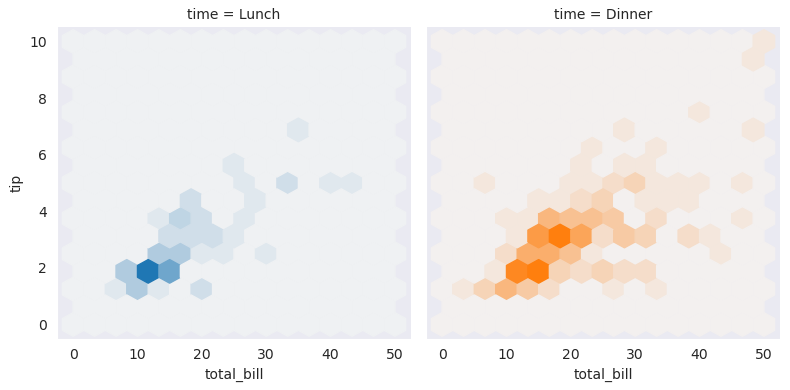

In [14]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(tips, hue="time", col="time", height=4)
g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10]);

### Plotting pairwise data relationships
PairGrid also allows you to quickly draw a grid of small subplots using the same plot type to visualize data in each. In a PairGrid, each row and column is assigned to a different variable, so the resulting plot shows each pairwise relationship in the dataset. This style of plot is sometimes called a “scatterplot matrix”, as this is the most common way to show each relationship, but PairGrid is not limited to scatterplots.

It’s important to understand the differences between a FacetGrid and a PairGrid. In the former, each facet shows the same relationship conditioned on different levels of other variables. In the latter, each plot shows a different relationship (although the upper and lower triangles will have mirrored plots). Using PairGrid can give you a very quick, very high-level summary of interesting relationships in your dataset.

The basic usage of the class is very similar to FacetGrid. First you initialize the grid, then you pass plotting function to a map method and it will be called on each subplot. There is also a companion function, pairplot() that trades off some flexibility for faster plotting.

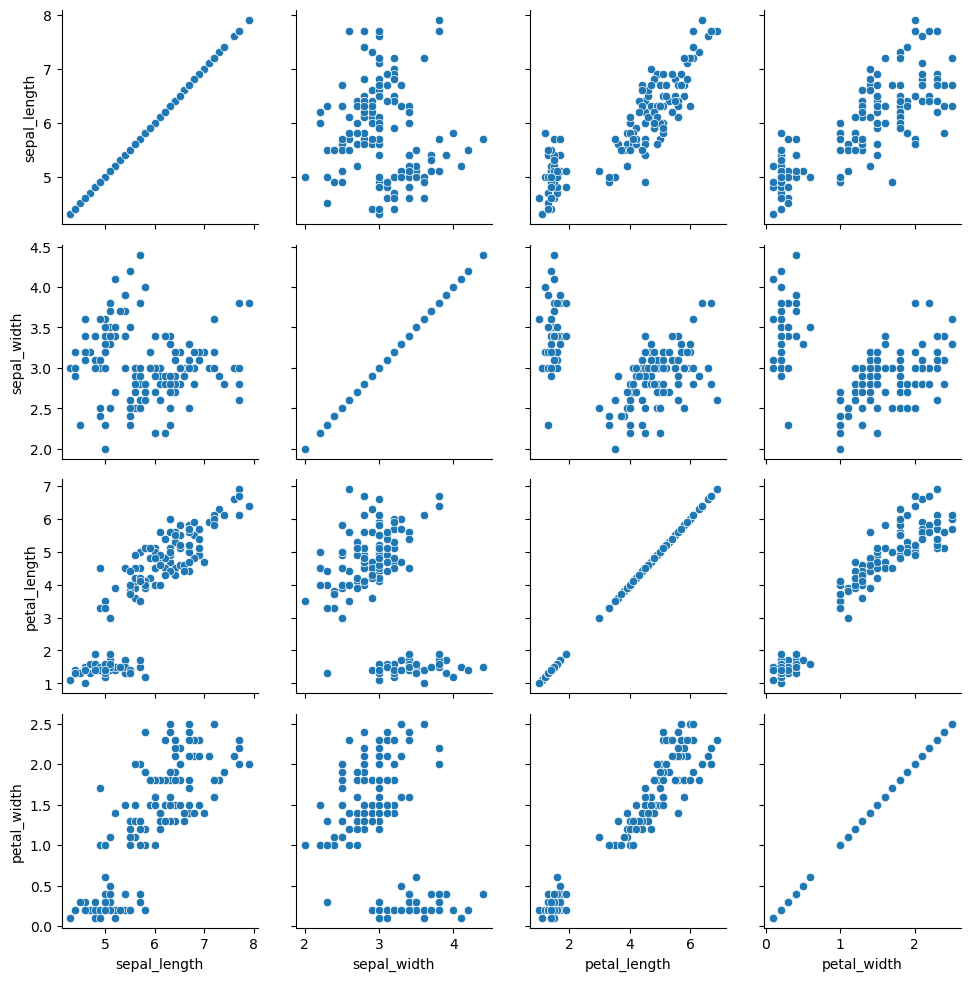

In [15]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g.map(sns.scatterplot)

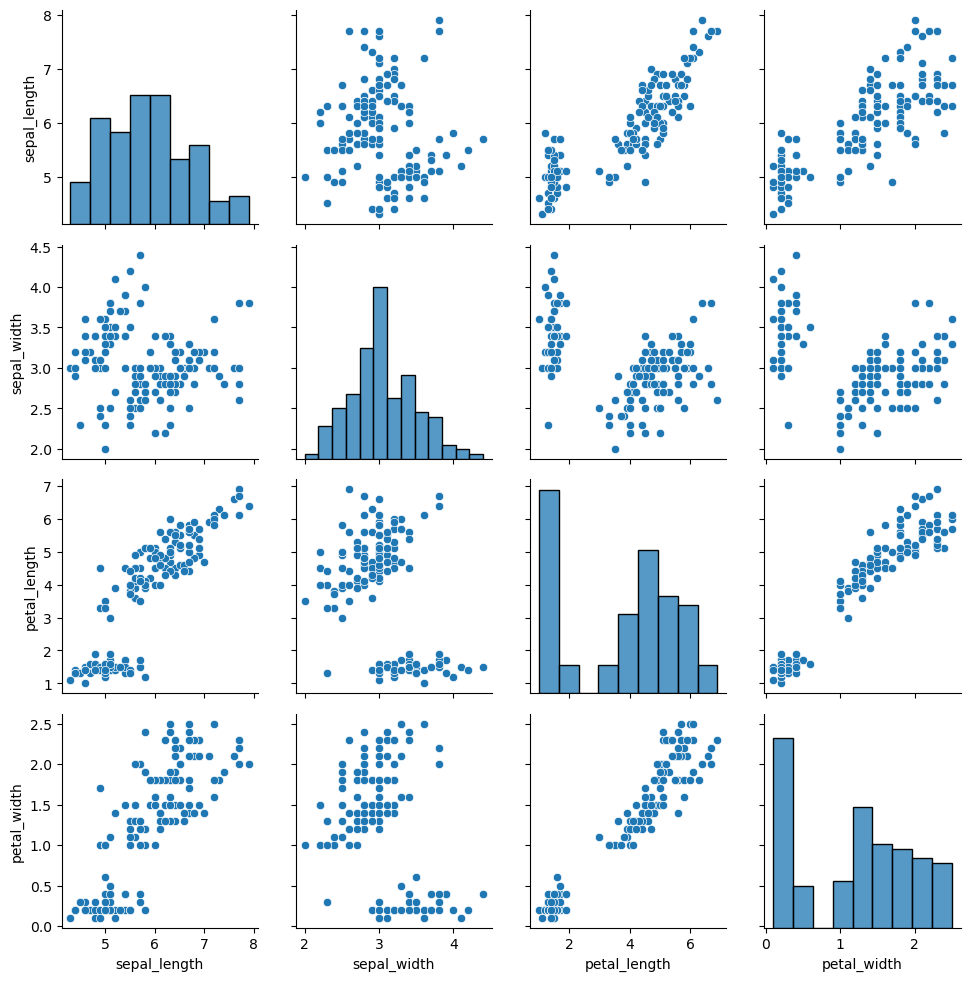

In [16]:
g = sns.PairGrid(iris)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

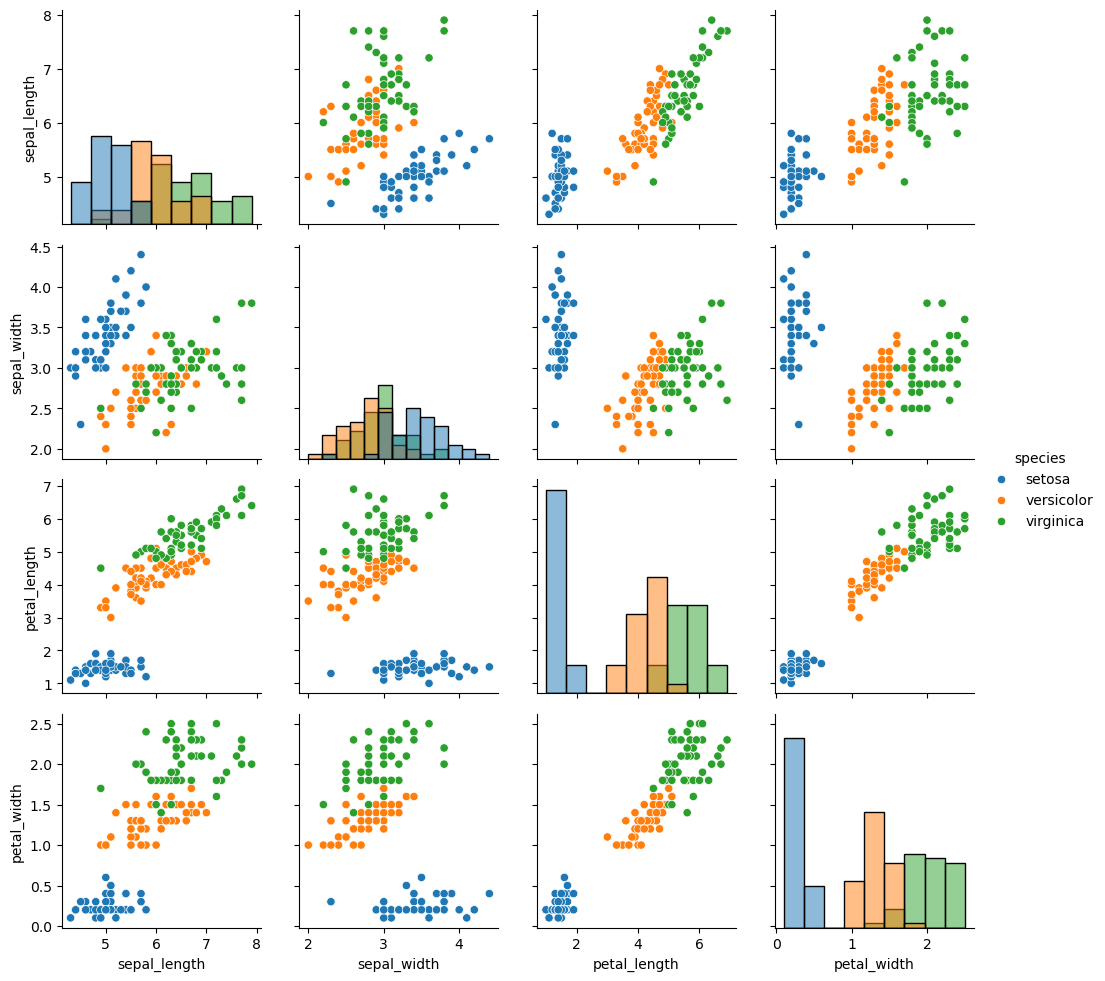

In [17]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

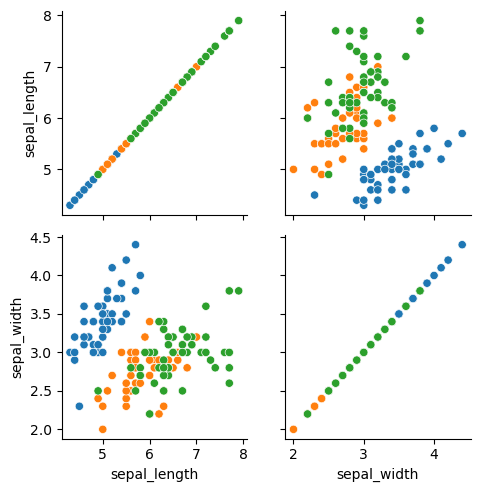

In [18]:
g = sns.PairGrid(iris, vars=["sepal_length", "sepal_width"], hue="species")
g.map(sns.scatterplot)

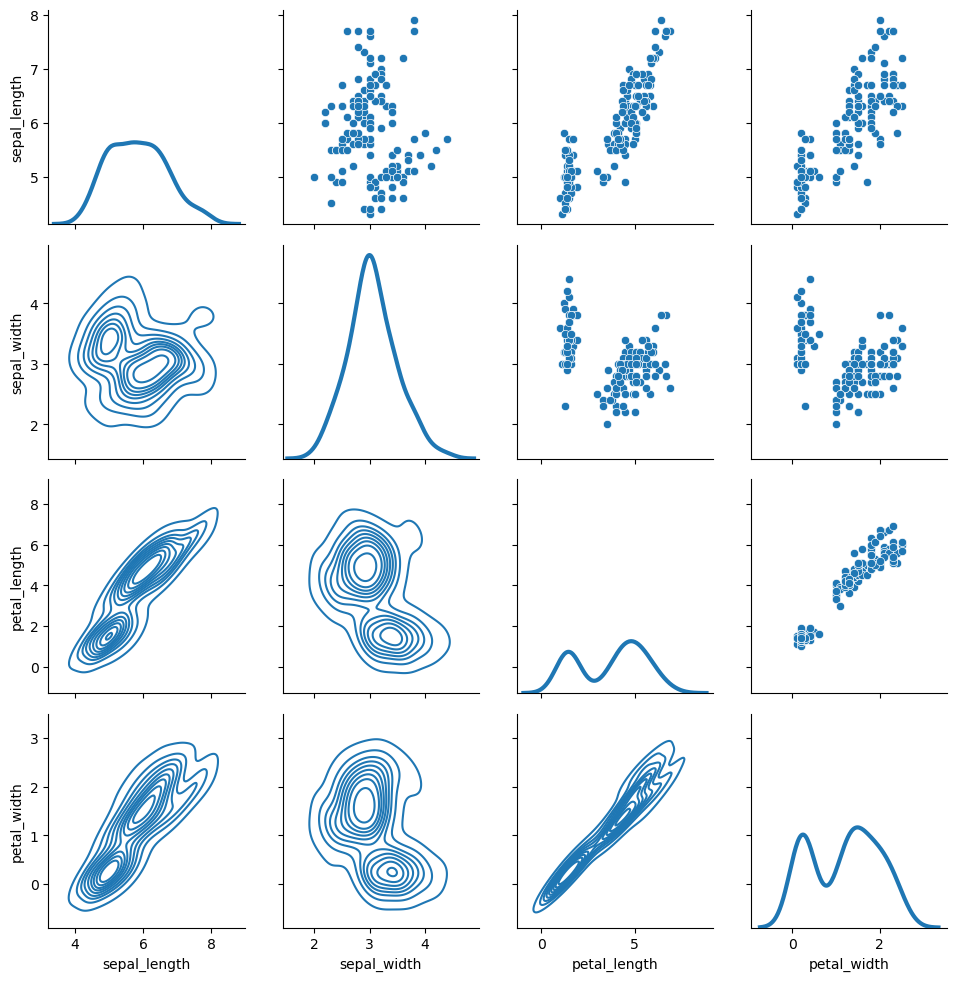

In [19]:
g = sns.PairGrid(iris)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

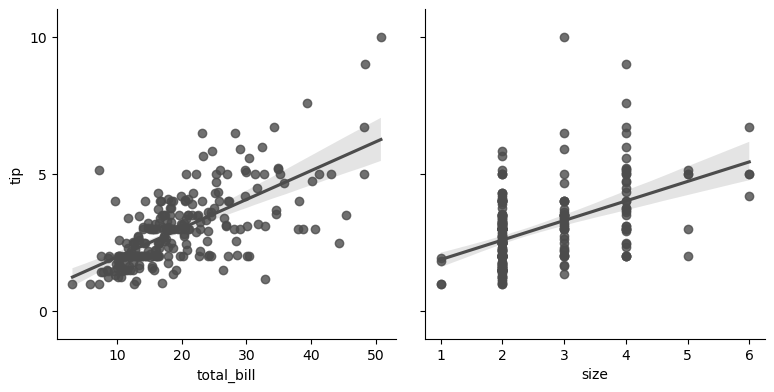

In [20]:
g = sns.PairGrid(tips, y_vars=["tip"], x_vars=["total_bill", "size"], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

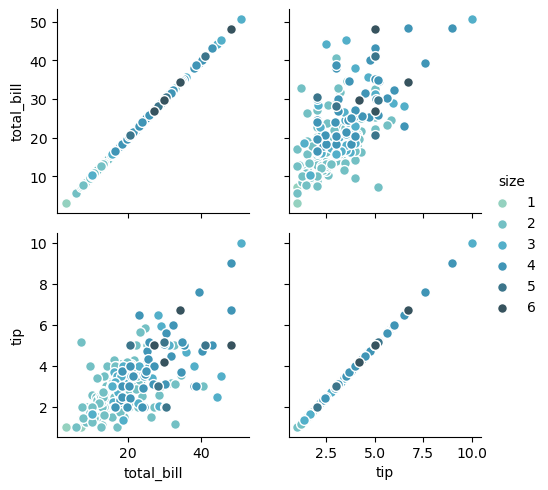

In [21]:
g = sns.PairGrid(tips, hue="size", palette="GnBu_d")
g.map(plt.scatter, s=50, edgecolor="white")
g.add_legend()

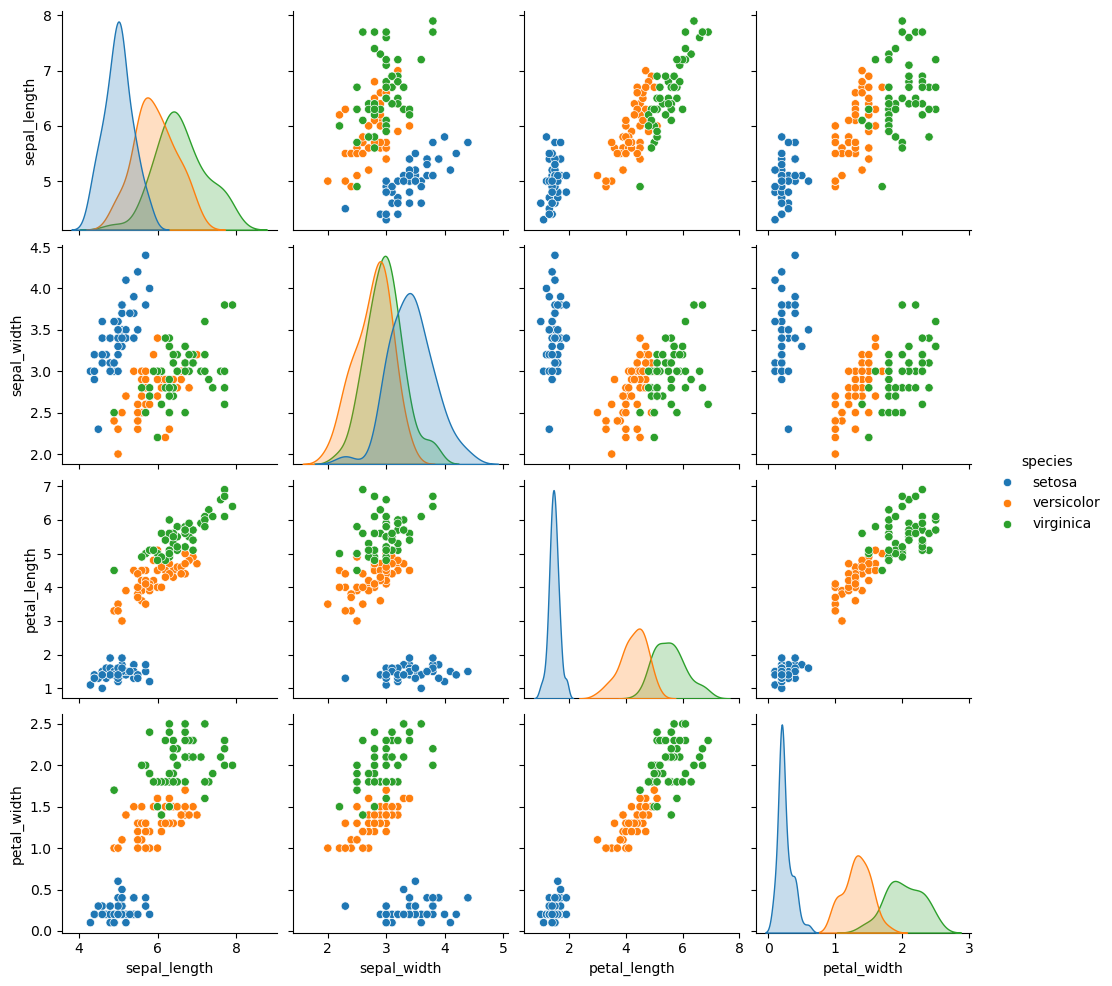

In [22]:
sns.pairplot(iris, hue="species", height=2.5)

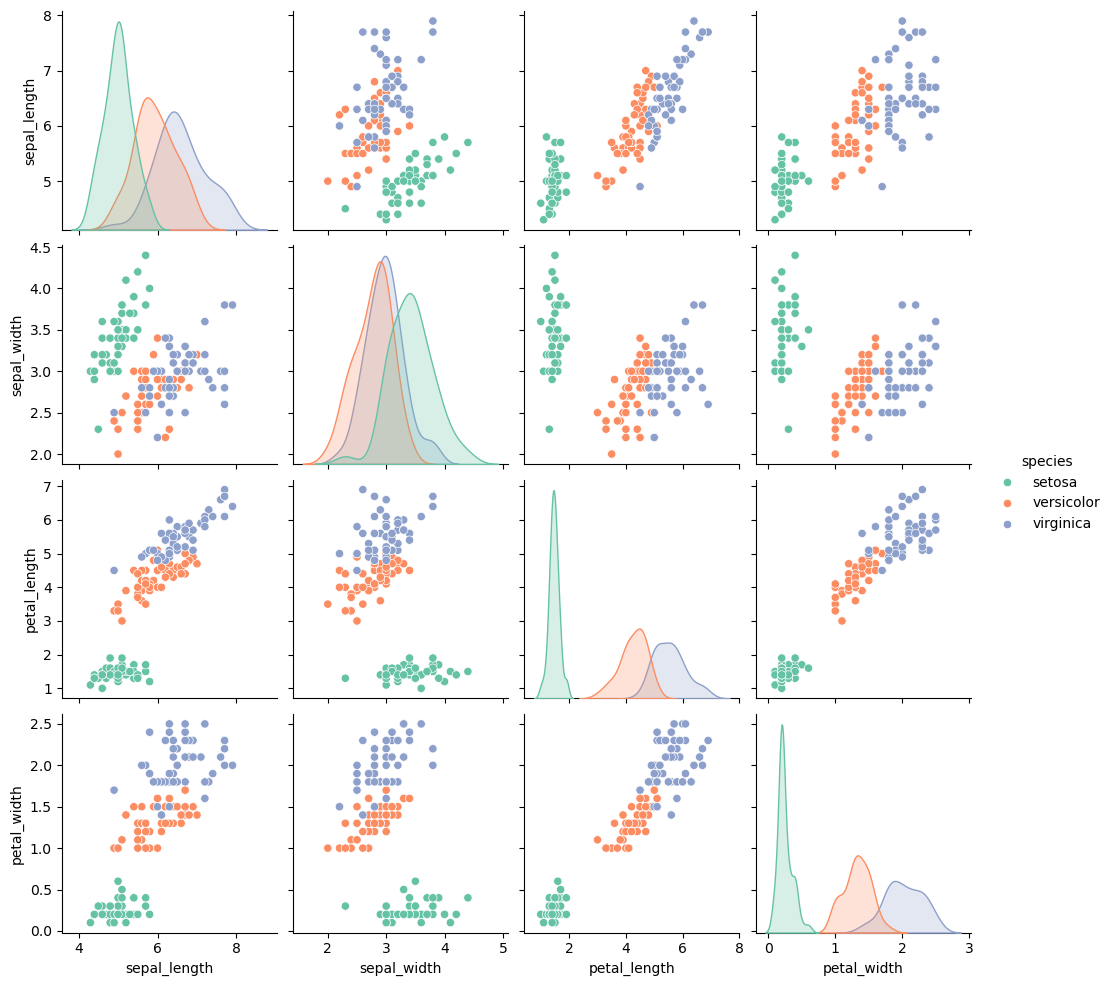

In [23]:
g = sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", height=2.5)